In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras import losses, metrics, optimizers, initializers, regularizers

np.random.seed(42)
import pickle
%load_ext autoreload
%autoreload

Using TensorFlow backend.


In [5]:
train_raw = pd.read_csv('train.csv')
train_raw = train_raw.copy()
test_X_raw = pd.read_csv('test.csv')
test_X_raw = test_X_raw.copy()

In [6]:
train_X_raw = train_raw[train_raw.columns[1:]]
train_Y_raw = train_raw['label']

In [7]:
X_raw = pd.concat([train_X_raw, test_X_raw])

In [8]:
print('train_X_raw shape:', train_X_raw.shape)
print('test_X_raw shape:', test_X_raw.shape)
print('X_raw shape:', X_raw.shape)
print('train_X_raw.shape[0] + test_X_raw.shape[0] =', train_X_raw.shape[0] + test_X_raw.shape[0])

train_X_raw shape: (42000, 784)
test_X_raw shape: (28000, 784)
X_raw shape: (70000, 784)
train_X_raw.shape[0] + test_X_raw.shape[0] = 70000


In [9]:
# Look at Y value distribution

In [10]:
train_Y_raw.value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

In [11]:
# Check missing value

In [12]:
train_Y_raw.isnull().sum()

0

In [13]:
X_raw.isnull().sum().value_counts()

0    784
dtype: int64

In [14]:
# Y value one hot transformation

In [15]:
train_Y_pre_transform = train_Y_raw.copy()
train_Y_pre_split = OneHotEncoder(sparse=False).fit_transform(train_Y_pre_transform.values.reshape(-1,1))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [16]:
train_Y_raw.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [17]:
train_Y_pre_split

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [18]:
# X value transformation

In [19]:
X_pre_transform = X_raw.copy()
X = np.divide(X_pre_transform, 255)

In [20]:
# X value reshape
# according to the description file for the dataset
# reshape image in 3 dimensions (height=28px, width=28px , channel=1)

In [21]:
X = X.values.reshape(-1, 28, 28, 1)

In [22]:
# Look at a record

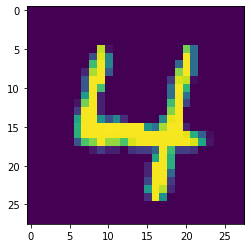

In [23]:
number = 42
plt.imshow(X[number][:,:,0])

In [24]:
# Create train, dev, test sets

In [25]:
X.shape

(70000, 28, 28, 1)

In [26]:
train_X_pre_split = X[:train_X_raw.shape[0]]

In [27]:
test_X = X[train_X_raw.shape[0]:]

In [28]:
print('train_X_raw shape:', train_X_raw.shape)
print('train_X_pre_split shape:', train_X_pre_split.shape)
print('test_X shape:', test_X.shape)
print('train_X_raw.shape[0] + test_X.shape[0] =', train_X_pre_split.shape[0] + test_X.shape[0])

train_X_raw shape: (42000, 784)
train_X_pre_split shape: (42000, 28, 28, 1)
test_X shape: (28000, 28, 28, 1)
train_X_raw.shape[0] + test_X.shape[0] = 70000


In [29]:
train_X, dev_X, train_Y, dev_Y = train_test_split(train_X_pre_split, train_Y_pre_split, random_state=42)

In [30]:
print('train X shape:', train_X.shape)
print('train Y shape:', train_Y.shape)
print('dev X shape:', dev_X.shape)
print('dev Y shape:', dev_Y.shape)

train X shape: (31500, 28, 28, 1)
train Y shape: (31500, 10)
dev X shape: (10500, 28, 28, 1)
dev Y shape: (10500, 10)


In [31]:
def model_cnn(train_X, train_Y, dev_X, dev_Y, 
              optimizer='Adam', kernel_initializer='he_normal', bias_initializer='he_normal', batch_size=32, epochs=50, verbose=1):

    from keras.preprocessing.image import ImageDataGenerator
    from keras.callbacks import ReduceLROnPlateau
    from keras.models import Sequential
    from keras.layers import (Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten)
    from keras import losses
    from keras import metrics
    from keras import optimizers
    from keras import initializers
    from keras import regularizers
    
    model = Sequential()
    
    model.add(Conv2D(64, activation='relu', kernel_size=(3, 3), padding='Same', input_shape=(28, 28, 1), 
                     kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(Conv2D(128, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(Conv2D(256, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=optimizer, 
                  loss=losses.categorical_crossentropy, 
                  metrics=['accuracy'])
    
    image_augmentation = ImageDataGenerator(
                        featurewise_center=False, samplewise_center=False, 
                        featurewise_std_normalization=False, samplewise_std_normalization=False, 
                        zca_whitening=False, zca_epsilon=1e-06, 
                        rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, 
                        brightness_range=None, shear_range=0.0, zoom_range=0.1, channel_shift_range=0.0, 
                        fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False)
    
    image_augmentation.fit(train_X)
    
    lr_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
    
    
    history = model.fit_generator(image_augmentation.flow(train_X,train_Y, batch_size=batch_size),
                                  epochs=epochs, validation_data=(dev_X, dev_Y), 
                                  steps_per_epoch=np.ceil(train_X.shape[0]/batch_size), 
                                  verbose=verbose,
                                  callbacks=[lr_reduction])
    return model, history

In [32]:
def plot_result(history):
    import matplotlib.pyplot as plt

    print('train set loss: {:.4f}'.format(history.history['loss'][-1]))
    print('dev set loss: {:.4f}'.format(history.history['val_loss'][-1]))
    print('train set accuracy: {:.4f}'.format(history.history['acc'][-1]))
    print('dev set accuracy: {:.4f}'.format(history.history['val_acc'][-1]))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Dev Loss'], loc='upper right')
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Accuracy', 'Dev Accuracy'], loc='upper right')
    plt.show()

In [33]:
model, history = model_cnn(train_X, train_Y, dev_X, dev_Y, 
                           optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), 
                           batch_size=1024, epochs=50)



Epoch 1/50
 3/31 [=>............................] - ETA: 6:59 - loss: 9.5768 - accuracy: 0.1012

KeyboardInterrupt: 

In [ ]:
output_csv01 = pd.DataFrame(data=[test_X_raw.index.values, y01]).T
output_csv01.columns = ['Id', 'SalePrice']
output_csv01 = output_csv01.astype('float')
output_csv01.to_csv('./outputs/output_csv01.csv', index=False)